# git

In [1]:
%cd "/content/drive/My Drive/ML_and_CNN/VGG16"

/content/drive/My Drive/ML_and_CNN/VGG16


In [16]:
!ls

drone_and_vgg16.ipynb


In [ ]:
!git config --list --local

core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true
core.symlinks=false
user.email=grushevskaya.d.v@yandex.ru
user.name=Geraldina (Colaboratory)


In [ ]:
!git status

In [17]:
!git add .

In [18]:
!git commit -m "Какое-то из изображений некорректно, вылетает ошибка"

[master edab043] Какое-то из изображений некорректно, вылетает ошибка
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite drone_and_vgg16.ipynb (93%)


In [19]:
!git log -1

commit edab043c6dfd71ac9c60599fc08ad313cbda092d (HEAD -> master)
Author: Geraldina (Colaboratory) <grushevskaya.d.v@yandex.ru>
Date:   Tue Aug 18 13:44:11 2020 +0000

    Какое-то из изображений некорректно, вылетает ошибка


In [ ]:
%cd "/content"

/content


In [ ]:
!ls

# Code

### Разархивация

In [ ]:
!ls "/content/drive/My Drive/ML_and_CNN/data"

drone_photo.zip


In [ ]:
import zipfile

path_to_zip_file = "drive/My Drive/ML_and_CNN/data/drone_photo.zip"
directory_to_extract_to = "photo"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
fromDirectory = "drive/My Drive/ML_and_CNN/data/not_drone_photo"
toDirectory = "photo/not_drone_photo"

copy_tree(fromDirectory, toDirectory)

### Создание подкаталогов

In [2]:
# Каталог с набором данных
data_dir = 'drive/My Drive/ML_and_CNN/data'

# Каталог с данными для обучения
train_dir = 'drive/My Drive/ML_and_CNN/vgg16_data/train'
# Каталог с данными для проверки
val_dir = 'drive/My Drive/ML_and_CNN/vgg16_data/val'
# Каталог с данными для тестирования
test_dir = 'drive/My Drive/ML_and_CNN/vgg16_data/test'

# Часть набора данных для тестирования
test_data_portion = 0.15
# Часть набора данных для проверки
val_data_portion = 0.15
# Количество элементов данных в одном классе
nb_images = 5373 # min

In [4]:
import os

def create_directory(dir_name):
    """ Функция создания каталога с двумя подкаталогами по названию классов """
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "bird"))
    os.makedirs(os.path.join(dir_name, "drone"))

In [5]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

In [13]:
import shutil

def copy_images(start_index, end_index, source_dir, dest_dir):
    """ Функция копирования изображений в заданный каталог. """
    for i in range(start_index, end_index):
        shutil.copy2(os.path.join(source_dir, "bird", str(i).zfill(6) + ".jpg"), 
                    os.path.join(dest_dir, "bird"))
        shutil.copy2(os.path.join(source_dir, "drone", str(i).zfill(6) + ".jpg"), 
                   os.path.join(dest_dir, "drone"))

In [12]:
# Расчет индексов наборов данных для обучения, приверки и тестирования
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_val_data_idx)
print(start_test_data_idx)

3761
4567


In [14]:
# Копирование изображений
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

In [ ]:
!find train val test | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/"

### Обучение

In [1]:
%cd "/content/drive/My Drive/ML_and_CNN/VGG16"

/content/drive/My Drive/ML_and_CNN/VGG16


In [2]:
# Каталог с данными для обучения
train_dir = '/content/drive/My Drive/ML_and_CNN/vgg16_data/train'
# Каталог с данными для проверки
val_dir = '/content/drive/My Drive/ML_and_CNN/vgg16_data/val'
# Каталог с данными для тестирования
test_dir = '/content/drive/My Drive/ML_and_CNN/vgg16_data/test'

In [3]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

In [20]:
# Если на вашем изображении отсутствуют данные, оно будет заполнено серым цветом

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Размеры изображения
img_width, img_height = 150, 150

# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)

# Количество эпох
epochs = 125
# Размер мини-выборки
batch_size = 50

# Количество изображений для обучения
nb_train_samples = 7522
# Количество изображений для проверки
nb_validation_samples = 1612
# Количество изображений для тестирования
nb_test_samples = 1612

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 7522 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1612 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [7]:
vgg16_net = VGG16(
    weights="imagenet", 
    include_top=False, # Не будет загружена та часть сети, которая отвечает за классификацию
    input_shape=(150, 150, 3)
)
vgg16_net.trainable = False

model = Sequential()
model.add(vgg16_net)

model.add(Flatten()) # Выпрямление в одномерный вид
model.add(Dense(256)) # Полносвязный слой
model.add(Activation("relu")) # Полулинейная функция активации
model.add(Dropout(0.5)) # Регуляризация
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

In [8]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [35]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/My Drive/ML_and_CNN/VGG16/weights.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=2)

In [26]:
from datetime import datetime

import tensorflow as tf
from tensorflow import keras

# Clear out prior logging data.
!rm -rf logs/image

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [27]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
# Start TensorBoard.
%load_ext tensorboard
%tensorboard --logdir logs/image

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch=3, #nb_train_samples // batch_size,
    epochs=1, #epochs,
    validation_data=val_generator,
    validation_steps=1, #nb_validation_samples // batch_size,    
    callbacks=[checkpoint], #, tensorboard_callback, cm_callback],
)

3/3 [==============================] - ETA: 0s - loss: 1.1921e-07 - accuracy: 0.5000 
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/ML_and_CNN/VGG16/weights.hdf5
3/3 [==============================] - 139s 46s/step - loss: 1.1921e-07 - accuracy: 0.5000 - val_loss: 1.1921e-07 - val_accuracy: 0.5000


Визуализация

In [12]:
def plot_history(histories, key='categorical_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], 
             color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', history)])

NameError: ignored

### Сохранение модели

In [14]:
model.save("/content/drive/My Drive/ML_and_CNN/VGG16/model.h5")
!ls

drone_and_vgg16.ipynb  model.h5


### Загрузка модели

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model("/content/drive/My Drive/ML_and_CNN/VGG16/model.h5")
print(model2.summary())

### Проверка модели

In [ ]:
scores = model.evaluate(test_generator)
print("Точность: %.2f%%" % (scores[1] * 100))

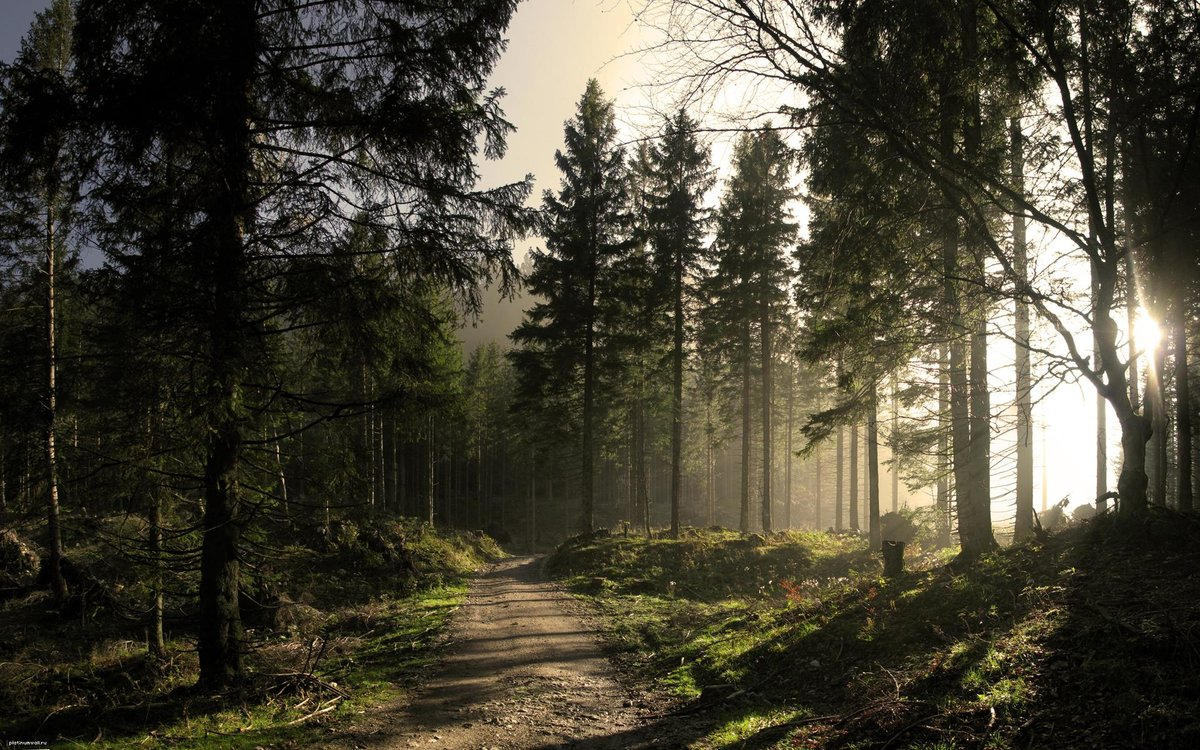

In [ ]:
from IPython.display import Image
name_image = "photo/not_drone_photo/s1200.jpg"
Image(name_image, width=200, height=200)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

my_image = image.load_img(name_image, target_size=(img_width, img_height))
my_image = image.img_to_array(my_image)
my_image = np.expand_dims(my_image, axis=0)

prediction = model.predict(my_image)
print("предсказание", prediction)

classes = ["bird", "drone", "not_drone"]

prediction = np.argmax(prediction)
print("результат предсказания:", classes[prediction])

предсказание [[2.1649494e-21]]
результат предсказания: drone
